<a href="https://colab.research.google.com/github/Walter-Phillips/Walter-Phillips.github.io/blob/main/RL_Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement Learning for Trading EURUSD in Forex Market**


> Using reinforcement learning to trade the Foreign Exchange Market. The market is the environment. Historical Data from 




### Import Dependencies

In [ ]:
!pip install tensorflow==1.15.0 tensorflow-gpu==1.15.0 gym gym_anytrading stable_baselines finta

In [25]:
import gym
import gym_anytrading


from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpLstmPolicy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from gym_anytrading.envs import ForexEnv
from finta import TA

In [32]:

EU = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv') #read csv file to Google Colab

### Clean Data and prepare for model

In [34]:
EU['timeindex'] = pd.to_datetime(EU['Date'].astype(str) + " " +EU['Time'].astype(str))
EU.set_index('timeindex', inplace = True)
EU.drop(['Date','Time','AO','AH','AL','AC','ACh'],axis = 1, inplace =True)
EU.columns = ['Open','High','Low','Close','Volume']
EU.head()

,Open,High,Low,Close,Volume
timeindex,,,,,
2005-05-02 00:00:00,1.2852,1.2852,1.2840,1.2844,-0.0008
2005-05-02 01:00:00,1.2844,1.2848,1.2839,1.2842,-0.0002
2005-05-02 02:00:00,1.2843,1.2854,1.2841,1.2851,0.0008
2005-05-02 03:00:00,1.2851,1.2859,1.2850,1.2851,0.0000
2005-05-02 04:00:00,1.2852,1.2859,1.2849,1.2855,0.0003


### Create Test Environment

info: {'total_reward': 1463.799999999945, 'total_profit': 0.5929199161887598, 'position': 0}


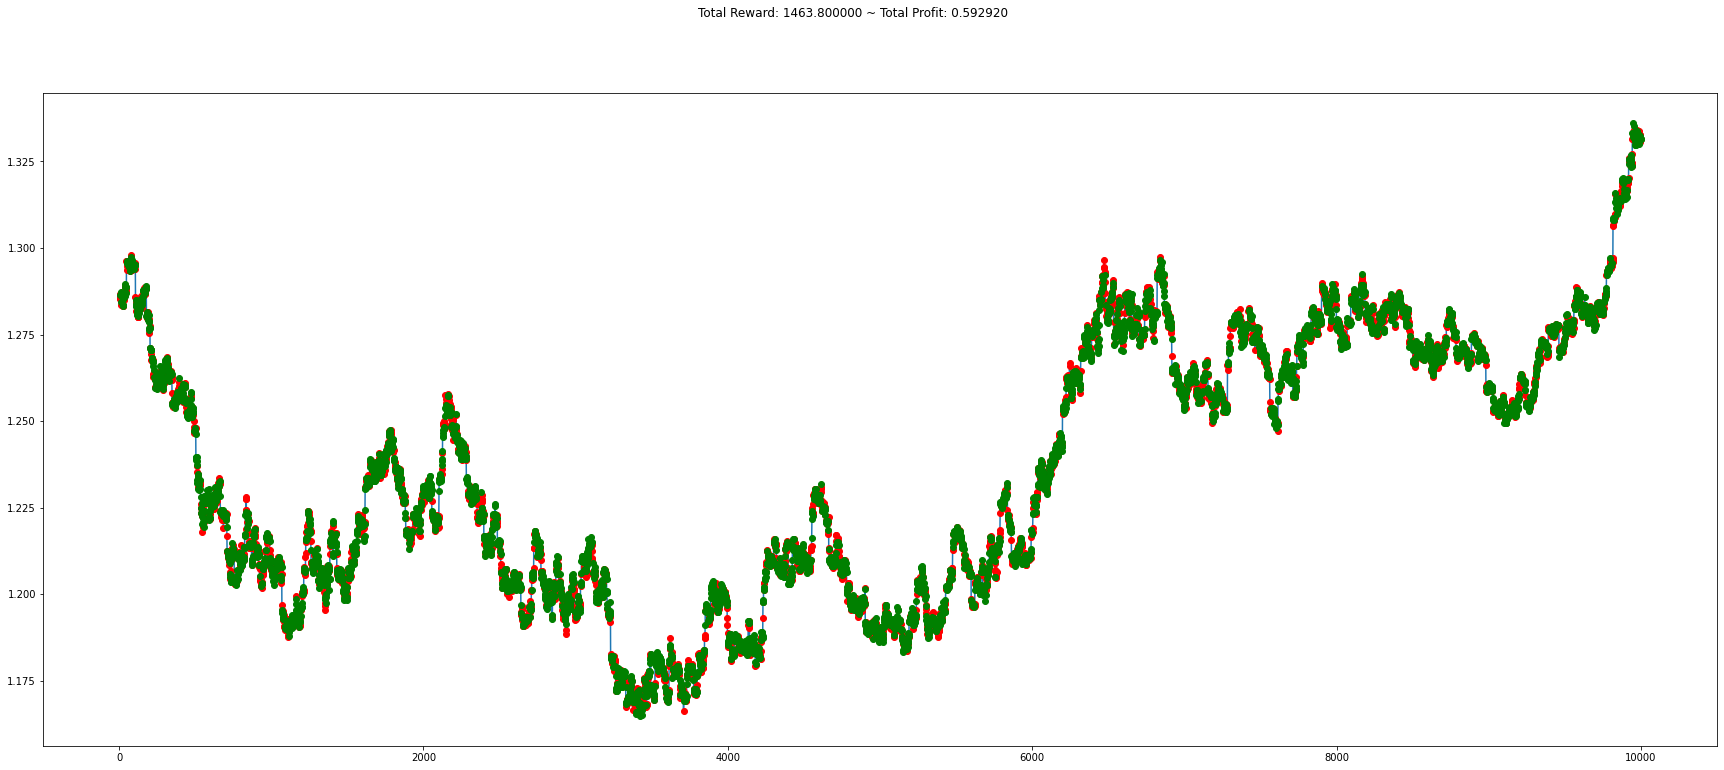

In [35]:
env = gym.make('forex-v0', df=EU, frame_bound=(5,10000), window_size=5, unit_side='right') #Environment made using OpenAi Gym, Stable Baselines and Gym Any_Trading

state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info:", info) #Show Reward Funtion Results and Profit
        break
    
plt.figure(figsize=(30,12)) #Plot Results
plt.cla()
env.render_all()
plt.show()

### Create Forex Indicators

In [ ]:
df['SMA'] = TA.SMA(df, 7)
df['SMA'] = TA.SMA(df, 15)
df.fillna(0, inplace=True) #fills empty colums for lagging Moving Averages

### Input Forex Indicators in Environment

In [ ]:
def add_signals(env):
  start = env.frame_bound[0] - env.window_size
  end = env.frame_bound[1]
  prices = env.EU.loc[:, 'Low'].to_numpy()[start:end]
  signal_features = env.EU.loc[:, ['Low', 'SMA15', 'SMA7']].to_numpy()[start:end]

### Create Real Environment

In [ ]:
class MyForexEnv(ForexEnv):
  _process_data = add_signals

env2 = MyForexEnv(df=EU, frame_bound=(7,1000), window_size=7, unit_side='right') #Environment with indicators

### Train Model

In [ ]:
env_maker = lambda:gym.make('forex-v0', df=EU, frame_bound=(5,1000), window_size=5, unit_side='right')
env = DummyVecEnv([env_maker]) #Environment without indicators

model = A2C('MlpLstmPolicy', env, verbose=1) #Using A2C DRL algorithm to train on data 
model.learn(total_timesteps=100000)

### Run Trained Model

In [ ]:
#Switch between Env and Env2 to see results
env = gym.make('forex-v0', df=EU, frame_bound=(5,1000), window_size=5, unit_side='right')
env2 = MyForexEnv(df=EU, frame_bound=(7,1000), window_size=7, unit_side='right')
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
        print("info:", info)
        break
plt.figure(figsize=(30,12))
plt.cla()
env.render_all()
plt.show()